# Recherche directe de politique

Dans ce TP, l'objectif est d'implémenter un algorithme de recherche directe de politique pour trouver une politique optimale pour l'environnement [CartPole](https://gymnasium.farama.org/environments/classic_control/cart_pole/).



In [32]:
import gymnasium as gym
import random
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import torch
from torch.distributions import Categorical
import utils
%matplotlib inline
%load_ext autoreload

def init_seed(seedval):
    torch.manual_seed(seedval)
    np.random.seed(seedval)
    random.seed(seedval)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
env = env = gym.make("CartPole-v1")

state_dim = env.observation_space.shape[0] 
action_dim = env.action_space.n
print("state dim : ",state_dim," et action dim :", action_dim)

state dim :  4  et action dim : 2


# 2 Définition de la Politique





In [34]:
class Politique():
    def __init__(self, dim_entree:int, dim_sortie:int, det = True):
        self.det = det
        self.poids = np.random.rand(dim_entree, dim_sortie)
 
    def output(self, etat : np.ndarray) -> int:
        output = np.dot(etat, self.poids)
        if self.det:
            return np.argmax(output)
        else:
            probabilites = torch.softmax(torch.tensor(output), dim=-1)
            distribution = Categorical(probabilites)
            action = distribution.sample().item()
            #print("action : ", action)
            return action
 
    def set_poids(self, poids: np.ndarray):
        self.poids = poids

    def get_poids(self) -> np.ndarray:
        return self.poids

    def save(self, file):
        np.save(file, self.poids)

    def load(self, file):
        return np.load(file)

In [35]:
def eval_politique(politique, env, nb_episodes=100, max_t=1000, seed=random.randint(0,5000), init_large=False) -> list:


    sum_rec = []
    for epi in range(1, nb_episodes+1):
        rec = []
        if init_large: 
            state, _ = env.reset(seed=seed,options={'low':-0.2,'high':0.2})
        else:
            state, _ = env.reset(seed=seed)
        for t in range(max_t):
            action = politique.output(state)
            # print("state : ",state)
            # print("action : ",action)
            state,reward,done, truncated , _ = env.step(action)
            rec.append(reward)
            if done or truncated:
               break
        somme = sum(rec)
        sum_rec.append(somme)
    return sum_rec




In [36]:
env = gym.make('CartPole-v1',render_mode="human")
init_seed(10)
print("politique deterministe : ")
politique_deterministe = Politique(dim_entree=4, dim_sortie=2,det=True) 
perf = eval_politique(politique_deterministe,env,seed=5,nb_episodes=5)
print(f"Perf  = {perf}")

print("politique  stochastique : ")
politique_stochastique = Politique(dim_entree=4, dim_sortie=2,det=False) 
perf = eval_politique(politique_stochastique,env,seed=5,nb_episodes=5)
print(f"Perf  = {perf}")
env.close()

politique deterministe : 
Perf  = [77.0, 77.0, 77.0, 77.0, 77.0]
politique  stochastique : 
Perf  = [13.0, 11.0, 11.0, 20.0, 24.0]


In [37]:
def rollout(politique, env,max_t=1000)-> int : 
    """
        execute un episode sur l'environnement env avec la politique et renvoie la somme des recompenses obtenues sur l'épisode
    """
    return eval_politique(politique,env,nb_episodes=1,max_t=max_t)[0]
    

def recherche_directe(politique, env,  nb_episodes=5000, max_t=1000) -> tuple[list,np.ndarray] :
    #TO COMPLETE
    bruit_std = 1e-2
    meilleur_perf = rollout(politique, env, max_t)
    meilleur_poids = politique.get_poids()
    performances = []
    cp = 0
    for i_episode in range(1, nb_episodes+1):
        poids_candidate = meilleur_poids + np.random.normal(0, bruit_std,size=meilleur_poids.shape)
        politique.set_poids(poids_candidate)
        perf = rollout(politique, env, max_t)
        performances.append(perf)
        if perf >= meilleur_perf:
            meilleur_perf = perf
            meilleur_poids = politique.get_poids()
            #reduction de la variance du bruit
            bruit_std = max(1e-3, bruit_std / 2)
            
            
        else:
            #augmentation de la variance du bruit
            bruit_std = min(2, bruit_std * 2)
        if perf==500:
            cp+=1
        if cp==100:
            break

        if i_episode % 20 == 0:
            print(f"Episode {i_episode}: meilleure performance = {meilleur_perf}, bruit_std = {bruit_std}")

    return performances, meilleur_poids
         

   

In [38]:
env = gym.make('CartPole-v1')
init_seed(5)
politique = Politique(dim_entree=4, dim_sortie=2,det=True) 
performances, meilleurs_poids_det = recherche_directe(politique=politique, env=env)
politique.set_poids(meilleurs_poids_det)
politique.save("best_pi_det.npy")
env.close()

Episode 20: meilleure performance = 9.0, bruit_std = 0.001
Episode 40: meilleure performance = 9.0, bruit_std = 0.001
Episode 60: meilleure performance = 9.0, bruit_std = 0.001
Episode 80: meilleure performance = 9.0, bruit_std = 0.001
Episode 100: meilleure performance = 9.0, bruit_std = 0.001
Episode 120: meilleure performance = 9.0, bruit_std = 0.001
Episode 140: meilleure performance = 9.0, bruit_std = 0.001
Episode 160: meilleure performance = 9.0, bruit_std = 0.001
Episode 180: meilleure performance = 9.0, bruit_std = 0.001
Episode 200: meilleure performance = 9.0, bruit_std = 0.001
Episode 220: meilleure performance = 9.0, bruit_std = 0.001
Episode 240: meilleure performance = 9.0, bruit_std = 0.001
Episode 260: meilleure performance = 9.0, bruit_std = 0.001
Episode 280: meilleure performance = 9.0, bruit_std = 0.001
Episode 300: meilleure performance = 9.0, bruit_std = 0.001
Episode 320: meilleure performance = 9.0, bruit_std = 0.001
Episode 340: meilleure performance = 9.0, br

In [39]:
env = gym.make('CartPole-v1')
init_seed(5)
politique = Politique(dim_entree=4, dim_sortie=2,det=False) 
performances, meilleurs_poids_stoc = recherche_directe(politique=politique, env=env)
politique.set_poids(meilleurs_poids_stoc)
politique.save("best_pi_stoc.npy")
env.close()

Episode 20: meilleure performance = 96.0, bruit_std = 1.0
Episode 40: meilleure performance = 411.0, bruit_std = 2
Episode 60: meilleure performance = 411.0, bruit_std = 2
Episode 80: meilleure performance = 411.0, bruit_std = 2
Episode 100: meilleure performance = 462.0, bruit_std = 2
Episode 120: meilleure performance = 462.0, bruit_std = 2
Episode 140: meilleure performance = 500.0, bruit_std = 2
Episode 160: meilleure performance = 500.0, bruit_std = 2
Episode 180: meilleure performance = 500.0, bruit_std = 0.001
Episode 200: meilleure performance = 500.0, bruit_std = 0.001
Episode 220: meilleure performance = 500.0, bruit_std = 0.001
Episode 240: meilleure performance = 500.0, bruit_std = 0.001


politique deterministe : 


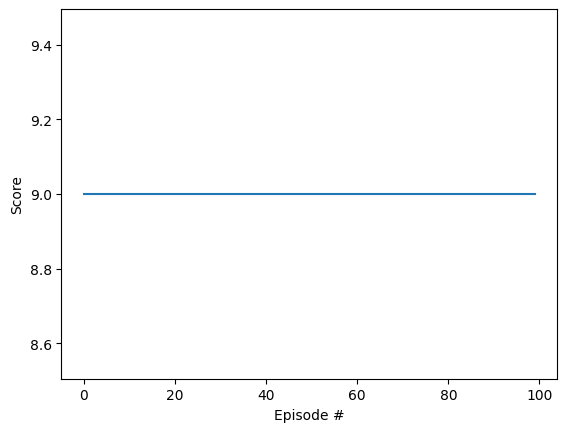

politique  stochastique : 


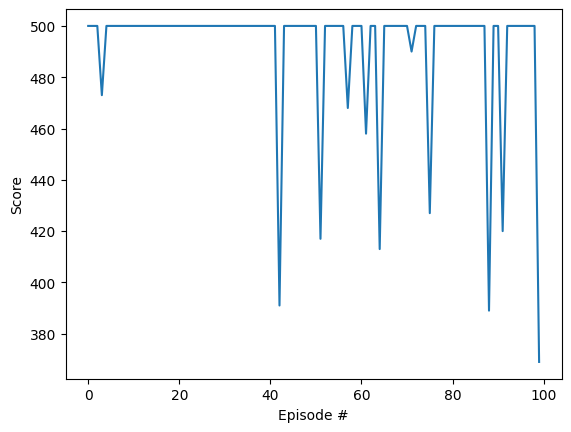

In [31]:
env = gym.make('CartPole-v1')
init_seed(5)

print("politique deterministe : ")
politique = Politique(dim_entree=4, dim_sortie=2,det=True) 
poids=politique.load("best_pi_det.npy")
politique.set_poids(poids)
perf1 = eval_politique(politique,env,seed=5,nb_episodes=100)
utils.plot_sumrwdperepi(perf1)

print("politique  stochastique : ")
politique = Politique(dim_entree=4, dim_sortie=2,det=False) 
poids=politique.load("best_pi_stoc.npy")
politique.set_poids(poids)
perf1 = eval_politique(politique,env,seed=5,nb_episodes=100)
utils.plot_sumrwdperepi(perf1)
env.close()